<a href="https://colab.research.google.com/github/l-fowler/neuromatch/blob/main/W3D3_OptimalControl/Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 2: Optimal Control for Continuous State

**Week 3, Day 3: Optimal Control**

**By Neuromatch Academy**

__Content creators:__ Zhengwei Wu, Shreya Saxena, Xaq Pitkow

__Content reviewers:__ Karolina Stosio, Roozbeh Farhoodi, Saeed Salehi, Ella Batty, Spiros Chavlis, Matt Krause and Michael Waskom

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

In this tutorial, we will implement a continuous control task. You will design control inputs for a linear dynamical system to reach a target state. The state here is continuous-valued, i.e., takes on any real number from $-\infty$ to $\infty$.

You have already learned about control for binary states in Tutorial 1, and you have learned about stochastic dynamics, latent states, and measurements yesterday. Now we introduce you to the new concepts of designing a controller with full observation of the state (linear quadratic regulator - LQR), and under partial observability of the state (linear quadratic gaussian - LQG).

The running example we consider throughout the tutorial is a cat trying to catch a mouse in space using its handy little jet pack to navigate. 

In this tutorial you will:

* Apply the ideas of optimal control to solve a toy example: Astrocat catching mice in space
* Design an optimal controller with a full observation of the state (linear quadratic regulator - LQR)
* Design an optimal controller under partial observability of the state (linear quadratic gaussian - LQG)

In [1]:
# @title Tutorial slides

# @markdown These are the slides for all videos in this tutorial.
from IPython.display import IFrame
IFrame(src="https://mfr.ca-1.osf.io/render?url=https://osf.io/8j5rs/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from collections import namedtuple

In [3]:
# @title Figure Settings
import ipywidgets as widgets
from IPython.display import HTML
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [4]:
# @title Plotting Functions

def plot_vs_time(s, slabel, color, goal=None, ylabel=None):
  plt.plot(s, color, label=slabel)
  if goal is not None:
    plt.plot(goal, 'm--', label='goal $g$')
  plt.xlabel("Time", fontsize=14)
  plt.legend(loc="upper right")

  if ylabel:
    plt.ylabel(ylabel, fontsize=14)


def plot_kf_state_vs_time(latent_states, estimates, title, goal=None):

  fig = plt.figure(figsize=(12, 4))
  plt.suptitle(title, y=1.05)
  gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

  ax0 = plt.subplot(gs[0])
  ax0.plot(latent_states, estimates, 'r.')
  ax0.plot(latent_states, latent_states, 'b')
  # ax0.set_xlim([min(estimates), max(estimates)])
  # ax0.set_ylim([min(estimates), max(estimates)])
  ax0.set_xlabel('Latent State')
  ax0.set_ylabel('Estimated State')
  ax0.set_aspect('equal')

  ax1 = plt.subplot(gs[1])
  ax1.plot(latent_states, 'b', label = 'Latent State')
  ax1.plot(estimates, 'r', label = 'Estimated State')

  if goal is not None:
    ax1.plot(goal, 'm--', label = 'goal')

  ax1.set_xlabel('Time')
  ax1.set_ylabel('State')
  ax1.legend(loc="upper right")
  plt.tight_layout()
  plt.show()

In [5]:
# @title Helper Functions

# Global variables
T = 50
standard_normal_noise = np.random.randn(T)
standard_normal_noise_meas = np.random.randn(T)
gaussian = namedtuple('Gaussian', ['mean', 'cov'])

class ExerciseError(AssertionError):
  pass


def test_lds_class(lds_class):
  from math import isclose
  ldsys = lds_class(ini_state=2., noise_var=0.)
  if not isclose(ldsys.dynamics(.9)[1], 1.8):
    raise ExerciseError("'dynamics' method is not correctly implemented!")
  if not isclose(ldsys.dynamics_openloop(.9, 2., np.zeros(ldsys.T)-1.)[1], -0.2):
    raise ExerciseError("'dynamics_openloop' method is not correctly implemented!")
  if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[0][1], 3.):
    raise ExerciseError("s[t] in 'dynamics_closedloop' method is not correctly implemented!")
  if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[1][0], .6):
    raise ExerciseError("a[t] in 'dynamics_closedloop' method is not correctly implemented!")
  ldsys.noise_var = 1.
  if isclose(ldsys.dynamics(.9)[1], 1.8):
    raise ExerciseError("Did you forget to add noise to your s[t+1] in 'dynamics'?")
  if isclose(ldsys.dynamics_openloop(.9, 2., np.zeros(ldsys.T)-1.)[1], -0.2):
    raise ExerciseError("Did you forget to add noise to your s[t+1] in 'dynamics_openloop'?")
  if isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[0][1], 3.):
    raise ExerciseError("Did you forget to add noise to your s[t+1] in 'dynamics_closedloop'?")
  if not isclose(ldsys.dynamics_closedloop(.9, 2., np.zeros(ldsys.T)+.3)[1][0], .6):
    raise ExerciseError("Your input a[t] should not be noisy in 'dynamics_closedloop'.")

  print('Well Done!')


def test_lqr_class(lqr_class):
  from math import isclose
  lqreg = lqr_class(ini_state=2., noise_var=0.)
  lqreg.goal = np.array([-2, -2])
  s = np.array([1, 2])
  a = np.array([3, 4])
  if not isclose(lqreg.calculate_J_state(s), 25):
    raise ExerciseError("'calculate_J_state' method is not correctly implemented!")
  if not isclose(lqreg.calculate_J_control(a), 25):
    raise ExerciseError("'calculate_J_control' method is not correctly implemented!")

  print('Well Done!')

---
# Section 1: Exploring a Linear Dynamical System (LDS) with Open-Loop and Closed-Loop Control

In [6]:
# @title Video 1: Flying Through Space
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1Zv411B7WV", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="MLUTR8z16jI", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)


In this example, a cat is trying to catch a mouse in space. The location of the mouse is the goal state $g$, here a static goal. Later on, we will make the goal time-varying, i.e., $g(t)$. The cat's location is the state of the system $s_t$. The state has its internal dynamics: think of the cat drifting slowly in space. These dynamics are such that the state at the next time step $s_{t+1}$ are a linear function of the current state $s_t$. There is some process noise affecting the state (think about engine corrosions on the little jetpack causing unintended movements) here modeled as Gaussian noise $w_t$.

The control input or action $a_t$ is the action of the jet pack, which has an effect $Ba_t$ on the state at the next time step $s_{t+1}$. In this tutorial, we will be designing the action $a_t$ to reach the goal $g$, with known state dynamics.

Thus, our linear discrete-time system evolves according to the following equation:

\begin{align}
s_{t+1} &= Ds_t + Ba_t + w_t \tag{1}\\
s_{0} &= s_{init}
\end{align}

with 

$t$: time step, ranging from $1$ to $T$, where $T$ is the time horizon.

$s_t$: state at time $t$.

$a_t$: action at time $t$ (also known as "control input").

$w_t$: gaussian noise at time $t$.

$D$: transition matrix.

$B$: input matrix.

<br>

For simplicity, we will consider the 1D case, where the matrices reduce to scalars, and the states, control and noise are one-dimensional as well. Specifically, $D$ and $B$ are scalars.

We will consider the goal $g$ to be the origin, i.e., $g=0$, for Exercises 1 and 2.2. Later on, we will explore scenarios where the goal state changes over time $g(t)$.

<br>

**Stability**

The system is stable, i.e., the output remains finite for any finite initial condition $s_{init}$, if $|D| < 1$. Note that if the state dynamics are stable, the state eventually reaches $0$ (No control is needed!). However, when $|D|>1$ or the goal $g \neq 0$ selecting an appropriate sequence of actions becomes essential to completing the task.

<br>

**Open-loop control and Closed-loop linear control**

In *open-loop control*, $a_t$ is not a function of $s_t$. In *closed-loop linear control*, $a_t$ is a linear function of the state $s_t$. Specifically, $a_t$ is the control gain, $L_t$, multiplied by $s_t$, i.e., $a_t=L_t s_t$. 

In the next excercise, you will explore what happens when nothing is controlling the system, when the system is being controlled following an open-loop control policy, and when the system is under closed-loop linear control.

### Coding Exercise 1: Implement state evolution equations

Implement the state evolution equations in the class methods as provided below, for the following cases:

(a) no control: `def dynamics`

(b) open-loop control: `def dynamics_openloop`

(c) closed-loop control: `def dynamics_closedloop`

<br>

**Tip:** refer to Equation (1) above. The provided code uses the same notation.

In [8]:
class LDS:
  """
    T: Length of timeline (global, fixed variable)
    standard_normal_noise: Global noise of length T drawn from N(0, 1)
    noise: Gaussian noise N(mean, var) = mean + sqrt(var) * standard_normal_noise
    ...
  """
  def __init__(self, ini_state: float, noise_var: float, static_noise=False):
    self.ini_state = ini_state
    self.noise_var = noise_var
    self.T = T
    self.static_noise = static_noise

  def dynamics(self, D: float):
    s = np.zeros(T)  # states initialization
    s[0] = self.ini_state
    if self.static_noise:
      noise = np.sqrt(self.noise_var) * standard_normal_noise
    else:
      noise = np.sqrt(self.noise_var) * np.random.randn(T)

    for t in range(T - 1):
      ####################################################################
      ## Insert your code here to fill with the state dynamics equation
      ## without any control input
      ## complete the function and remove
      # raise NotImplementedError("Exercise: Please complete 'dynamics'")
      ####################################################################
      # calculate the state of t+1
      s[t + 1] = D * s[t] + noise[t]

    return s

  def dynamics_openloop(self, D: float, B: float, a: np.ndarray):

    s = np.zeros(T)  # states initialization
    s[0] = self.ini_state
    if self.static_noise:
      noise = np.sqrt(self.noise_var) * standard_normal_noise
    else:
      noise = np.sqrt(self.noise_var) * np.random.randn(T)

    for t in range(T - 1):
      ####################################################################
      ## Insert your code here to fill with the state dynamics equation
      ## with open-loop control input a[t]
      ## complete the function and remove
      # raise NotImplementedError("Please complete 'dynamics_openloop'")
      ####################################################################
      # calculate the state of t+1
      s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s

  def dynamics_closedloop(self, D: float, B: float, L: np.ndarray):

    s = np.zeros(T)  # states initialization
    a = np.zeros(T - 1)
    s[0] = self.ini_state

    if self.static_noise:
      noise = np.sqrt(self.noise_var) * standard_normal_noise
    else:
      noise = np.sqrt(self.noise_var) * np.random.randn(T)

    for t in range(T - 1):
      ####################################################################
      ## Insert your code here to fill with the state dynamics equation
      ## with closed-loop control input as a function of control gain L.
      ## complete the function and remove
      # raise NotImplementedError("Please complete 'dynamics_closedloop'")
      ####################################################################
      # calculate the current action
      a[t] = L[t] * s[t]
      # calculate the next state
      s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s, a


# Test your function
test_lds_class(LDS)

Well Done!


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial2_Solution_2a1f976e.py)



### Interactive Demo 1.1: Explore no control vs. open-loop control vs. closed-loop control

Once your code above passes the test, use the interactive demo below to visualize the effects of different kinds of control inputs.

(a) For the no-control case, can you identify two distinct outcomes, depending on the value of D? Why?

(b) The open-loop controller works well--or does it? Are there any problems in in challenging (high noise) conditions.

(c) Does the closed-loop controller fare better with the noise? Vary the values of $L$ and find a range where it quickly reaches the goal.

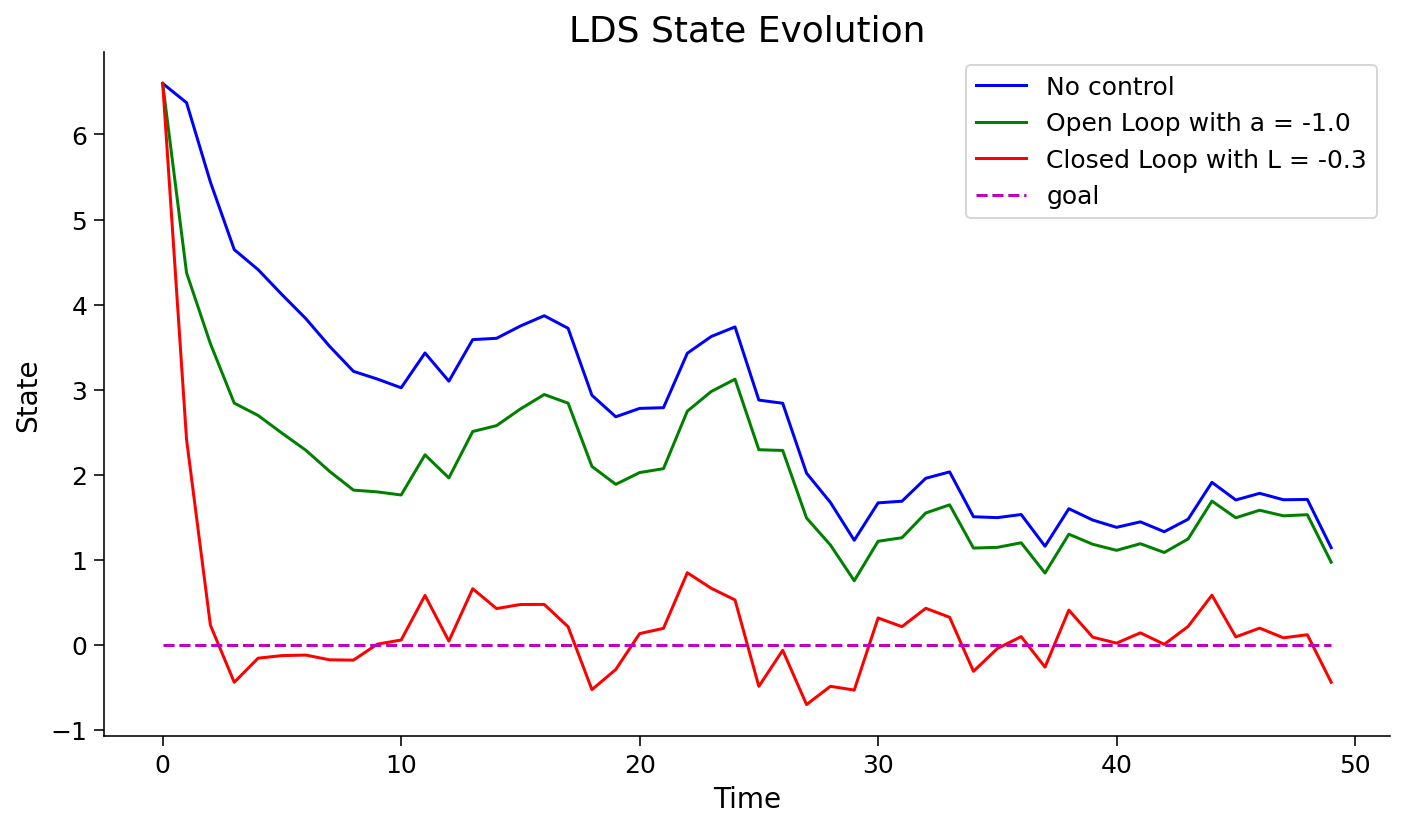

In [9]:
#@markdown Make sure you execute this cell to enable the widget!
#@markdown Play around (attentively) with **`a`** and **`L`** to see the effect on the open-loop controlled and closed-loop controlled state.

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(D=widgets.FloatSlider(0.95, description="D", min=0.85, max=1.05),
                  L=widgets.FloatSlider(-0.3, description="L", min=-0.6, max=0.),
                  a=widgets.FloatSlider(-1., description="a", min=-2., max=1.),
                  B=widgets.FloatSlider(2., description="B", min=1., max=3.),
                  noise_var=widgets.FloatSlider(.1, description="noise_var", min=0., max=.2),
                  ini_state=widgets.FloatSlider(2., description="ini_state", min=2., max=10.))

def simulate_lds(D=0.95, L=-0.3, a=-1., B=2., noise_var=0.1, ini_state=2.):
  """
    ...
  """
  static_noise = True

  # linear dynamical system
  lds = LDS(ini_state, noise_var, static_noise)

  # No control
  s_no_control=lds.dynamics(D)

  # Open loop control
  at = np.append(a, np.zeros(T - 1))
  s_open_loop = lds.dynamics_openloop(D, B, at)

  # Closed loop control
  Lt =  np.zeros(T) + L
  s_closed_loop, a_closed_loop = lds.dynamics_closedloop(D, B, Lt)

  plt.figure(figsize=(10, 6))
  plt.plot(s_no_control, 'b', label='No control')
  plt.plot(s_open_loop, 'g', label='Open Loop with a = {}'.format(a))
  plt.plot(s_closed_loop, 'r', label='Closed Loop with L = {}'.format(L))
  plt.plot(np.zeros(T), 'm--', label='goal')
  plt.title('LDS State Evolution')
  plt.ylabel('State', fontsize=14)
  plt.xlabel('Time', fontsize=14)
  plt.legend(loc="upper right")

plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial2_Solution_f62a6bbc.py)



### Interactive Demo 1.2: Exploring the closed-loop setting further 
Execute the cell below to visualize the MSE between the state and goal, as a function of control gain $L$. You should see a U-shaped curve, with a minimum MSE. The control gain at which the minimum MSE is reached, is the 'optimal' constant control gain for minimizing MSE, here called the numerical optimum. 

A green dashed line is shown $L = -\frac{D}{B}$ with $D=1.1$ and $B=2$. Why is this the theoretical optimal control gain for minimizing MSE of the state $s$ to the goal $g=0$? Examine how the states evolve with a constant gain $L$.

\begin{align}
s_{t+1} &= Ds_t + Ba_t + w_t \\
&= Ds_t + B(Ls_t) + w_t \\
&= (D+BL)s_t + w_t \tag{2}
\end{align}

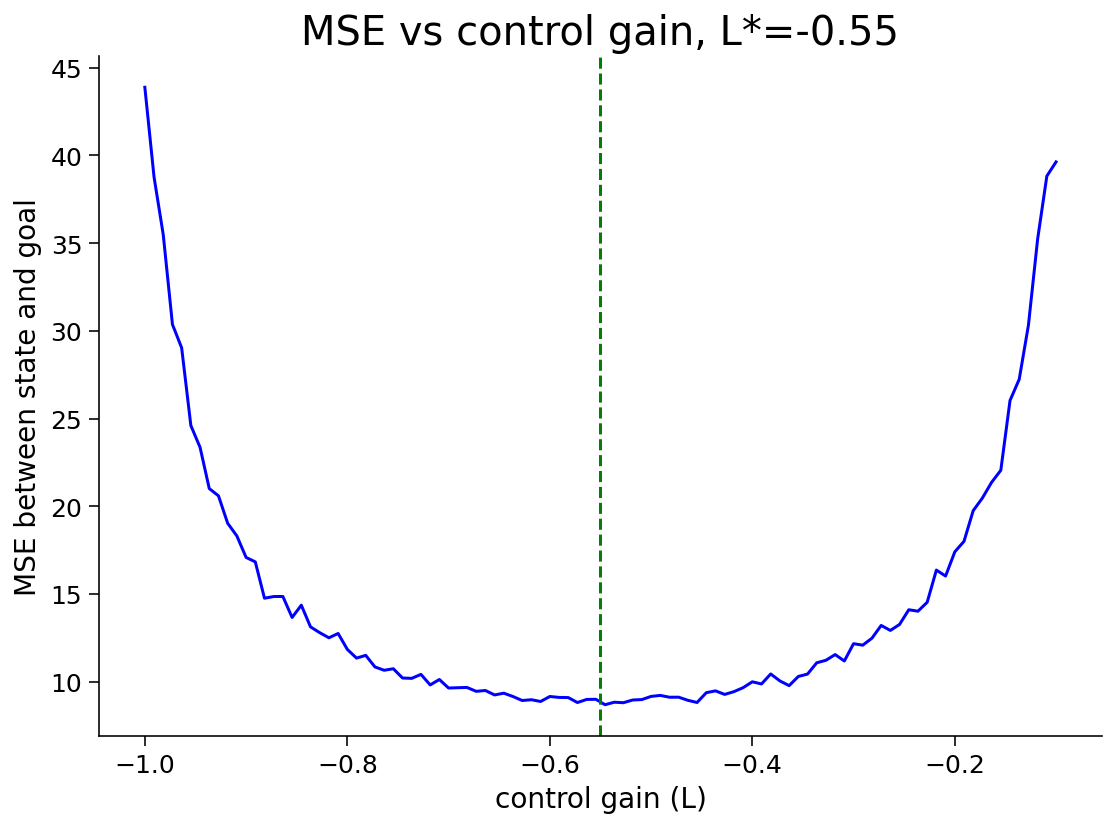

In [10]:
#@markdown Execute this cell to visualize MSE between state and goal, as a function of control gain
def calculate_plot_mse():
  D, B, noise_var, ini_state = 1.1, 2., 0.1, 2.
  num_iterations = 50
  num_candidates = 100

  control_gain_array = np.linspace(0.1, 1., num_candidates)
  mse_array = np.zeros([num_candidates, num_iterations])

  for j in range(num_iterations):
    for i in range(num_candidates):
      lds = LDS(ini_state, noise_var)
      L = - np.ones(T) * control_gain_array[i]
      s, a = lds.dynamics_closedloop(D, B, L)
      mse_array[i, j] = np.sum(s**2)

  opt = -control_gain_array[np.argmin(np.mean(mse_array, axis=1))]
  plt.figure()
  plt.plot(-control_gain_array, np.mean(mse_array, axis=1), 'b')
  plt.axvline(x=-D/B, color='g', linestyle='--')
  plt.xlabel("control gain (L)", fontsize=14)
  plt.ylabel("MSE between state and goal" , fontsize=14)
  plt.title(f"MSE vs control gain, L*={opt:0.2f}", fontsize=20)
  plt.show()
  return opt

opt = calculate_plot_mse()

Now, let's visualize the evolution of the system as we change the control gain. 

Using the next demo, explore the behavior of the system when over- and under- ambitious values of $L$ are used. The initial position of the slider corresponds to the optimal control gain $L^*$, the one that gets us the minimum MSE.

In [11]:
#@markdown Make sure you execute this cell to enable the widget!
#@markdown Explore different values of control gain **`L`** (close to optimal, over- and under- ambitious) \\

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(L=widgets.FloatSlider(opt, description="L", min=-1.05, max=0.051))

def simulate_L(L):

  D, B, noise_var, ini_state = 1.1, 2., 0.1, 2.
  static_noise  = True
  lds = LDS(ini_state, noise_var, static_noise)
  # Closed loop control with the numerical optimal control gain
  Lt = np.ones(T) * L
  s_closed_loop_choice, _ = lds.dynamics_closedloop(D, B, Lt)
  # Closed loop control with the theoretical optimal control gain
  L_theory = - D / B * np.ones(T)
  s_closed_loop_theoretical, _ = lds.dynamics_closedloop(D, B, L_theory)
  # Plotting closed loop state evolution with both theoretical and numerical optimal control gains
  plt.figure(figsize=(10, 6))
  plot_vs_time(s_closed_loop_theoretical,
                'Closed Loop (Theoretical optimal control gain)','b')
  plot_vs_time(s_closed_loop_choice,
                f'Closed Loop (your choice of L = {L:.2f})', 'g',
                goal=np.zeros(T), ylabel="State")
  plt.title(f'Closed-loop State Evolution. L* = {opt:.2f}')

plt.show()

interactive(children=(FloatSlider(value=-0.5454545454545454, description='L', max=0.051, min=-1.05), Output())…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial2_Solution_f883b5b2.py)



---
# Section 2: Designing an optimal control input using a linear quadratic regulator (LQR)

In [12]:
# @title Video 2: Linear quadratic regulator (LQR)
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1sz411v7za", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="NZSwDy7wtIs", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

## Section 2.1 Constraints on the system
Now we will start imposing additional constraints on our system. For example, if you explored different values for $s_{init}$ above, you would have seen very large values for $a_t$ in order to get to the mouse in a short amount of time. However, perhaps the design of our jetpack makes it dangerous to use large amounts of fuel in a single timestep. We certainly do not want to explode, so we would like to keep the actions $a_t$ as small as possible while still maintaining good control.

Moreover, in Exercise 1, we had restricted ourselves to a static control gain $L_t \equiv L$. How would we vary it if we could?

This leads us to a more principled way of designing the optimal control input.

### Setting up a cost function 

In a finite-horizon LQR problem,  the cost function is defined as: 

\begin{eqnarray}
J({\bf s},{\bf a}) &=& J_{state}({\bf s}) + \rho J_{control}({\bf a}) \\
 &=& \sum_{t = 0}^{T} (s_{t}-g)^2 + \rho \sum_{t=0}^{T-1}a_{t}^2 \tag{3}
\end{eqnarray}

where $\rho$ is the weight on the control effort cost, as compared to the cost of not being at the goal. Here, ${\bf a} = \{a_t\}_{t=0}^{T-1}$, ${\bf s} = \{s_t\}_{t=0}^{T}$. This is a quadratic cost function. In Exercise $2$, we will only explore $g=0$, in which case $J_{state}({\bf s})$ can also be expressed as $\sum_{t = 0}^{T} s_{t}^2$. In Exercise $3$, we will explore a non-zero time-varying goal.

<br>

The goal of the LQR problem is to find control ${\bf a}$ such that $J({\bf s},{\bf a})$ is minimized. The goal is then to find the control gain at each time point, i.e.,

\begin{equation}
\text{argmin} _{\{L_t\}_{t=0}^{T-1}}  J({\bf s},{\bf a}) \tag{4}
\end{equation}

where $a_t = L_t s_t$.

## Section 2.2 Solving LQR

The solution to Equation (4), i.e., LQR for a finite time horizon, can be obtained via Dynamic Programming. For details, check out [this lecture by Stephen Boyd](https://stanford.edu/class/ee363/lectures/dlqr.pdf).

For an infinite time horizon, one can obtain a closed-form solution using Riccati equations, and the solution for the control gain becomes time-invariant, i.e., $L_t \equiv L$. We will use this in Exercise 4. For  details, check out [this other lecture by Stephen Boyd](https://stanford.edu/class/ee363/lectures/dlqr-ss.pdf).

<br>

Additional reference for entire section:

[Bertsekas, Dimitri P. _Dynamic programming and optimal control_. Vol. 1. No. 2. Belmont, MA: Athena scientific, 1995](http://www.athenasc.com/dpbook.html).

### Coding Exercise 2.2: Implement the cost function

The cost function $J({\bf s}, {\bf a})$ can be divided into two parts: $J_{state}({\bf s})$ and $J_{control}({\bf a})$. 

Code up these two parts in the class methods `def calculate_J_state` and `def calculate_J_control` in the following helper class for LQR.

In [14]:
class LQR(LDS):
  def __init__(self, ini_state, noise_var, static_noise=False):
    super().__init__(ini_state, noise_var, static_noise)
    self.T = T
    self.goal = np.zeros(T)  # The class LQR only supports g=0

  def control_gain_LQR(self, D, B, rho):
    P = np.zeros(self.T)  # Dynamic programming variable
    L = np.zeros(self.T - 1)  # control gain
    P[-1] = 1
    for t in range(self.T - 1):
        P_t_1 = P[self.T - t - 1]
        P[self.T - t-2] = (1 + P_t_1 * D**2 - D * P_t_1 * B / (rho + P_t_1 * B**2) * B * P_t_1 * D)
        L[self.T - t-2] = - (1 / (rho + P_t_1 * B**2) * B * P_t_1 * D)
    return L

  def calculate_J_state(self, s:np.ndarray):
    ########################################################################
    ## Insert your code here to calculate J_state(s) (see Eq. 3)
    ## complete the function and remove
    # raise NotImplementedError("Please complete 'calculate_J_state'")
    ########################################################################
    # calculate the state
    J_state = np.sum((s - self.goal)**2)

    return J_state

  def calculate_J_control(self, a:np.ndarray):
    ########################################################################
    ## Insert your code here to calculate J_control(a) (see Eq. 3).
    ## complete the function and remove
    # raise NotImplementedError("Please complete 'calculate_J_control'")
    ########################################################################
    # calculate the control
    J_control = np.sum(a**2)

    return J_control


# Test class
test_lqr_class(LQR)

Well Done!


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial2_Solution_1aa39d33.py)



### Interactive Demo 2.2: LQR to the origin 

In this exercise, we will use your new LQR controller to track a static goal at $g=0$. Here, we will explore how varying $\rho$ (the weight on the control effort cost) affects the state trajectory, actions selected, and control gain.

1. Play around with the value of $\rho$ and see the effects on the sequence of states, the magnitude of the actions, and variability of control gain.
2. What do you notice on the control gain when $\rho$ is too large? and too small?
3. For different values of $\rho$, how does the magnitude of the actions change?

In [15]:
#@markdown Make sure you execute this cell to enable the widget!
#@markdown Explore different values of control gain **`L`** (close to optimal, over- and under- ambitious) \\

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(rho=widgets.FloatSlider(25., description="rho", min=0., max=50.))

def simulate_rho(rho=1.):
    D, B, ini_state, noise_var = 1.1, 2., 1., .1  # state parameter
    static_noise = True
    lqr = LQR(ini_state, noise_var, static_noise)
    L = lqr.control_gain_LQR(D, B, rho)
    s_lqr, a_lqr = lqr.dynamics_closedloop(D, B, L)

    plt.figure(figsize=(14, 4))
    plt.suptitle('LQR Control for rho = {}'.format(rho), y=1.05)

    plt.subplot(1, 3, 1)
    plot_vs_time(s_lqr,'State evolution','b',goal=np.zeros(T))
    plt.ylabel('State $s_t$')

    plt.subplot(1, 3, 2)
    plot_vs_time(a_lqr,'LQR Action','b')
    plt.ylabel('Action $a_t$')

    plt.subplot(1, 3, 3)
    plot_vs_time(L,'Control Gain','b')
    plt.ylabel('Control Gain $L_t$')

    plt.tight_layout()

plt.show()

interactive(children=(FloatSlider(value=25.0, description='rho', max=50.0), Output()), _dom_classes=('widget-i…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial2_Solution_4bfba957.py)



## Section 2.3: The tradeoff between state cost and control cost

In Exercise 2.1, you implemented code to calculate for $J_{state}$ and $J_{control}$ in the class methods for the class LQR.

We will now plot them against each other for varying values of $\rho$ to explore the tradeoff between state cost and control cost.

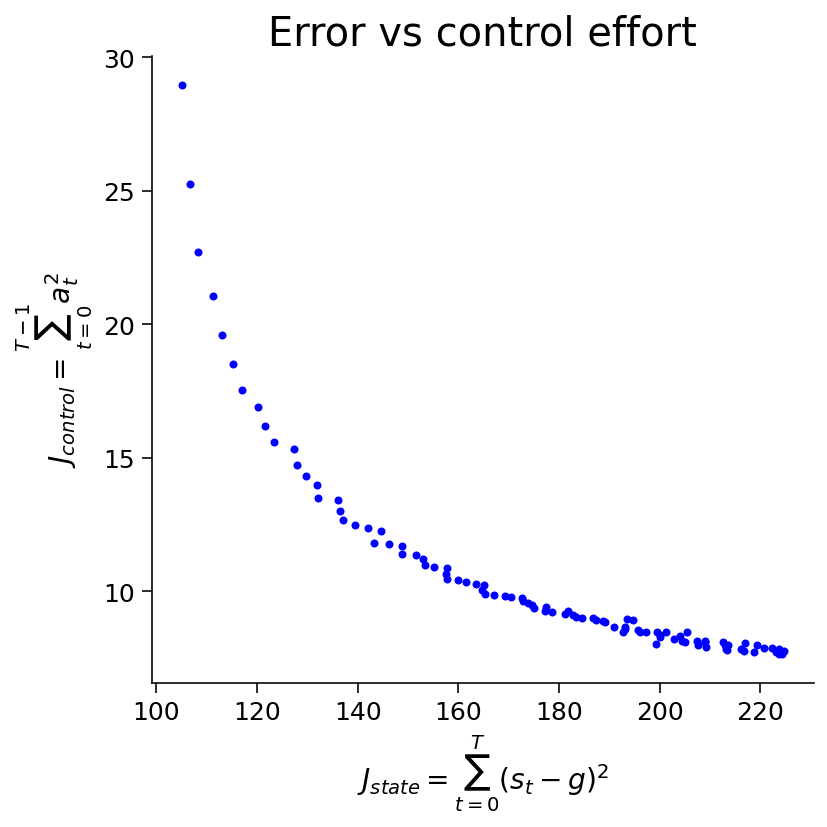

In [16]:
#@markdown Execute this cell to visualize the tradeoff between state and control cost
def calculate_plot_costs():

  D, B, noise_var, ini_state = 1.1, 2., 0.1, 10.
  num_iterations = 50
  num_candidates = 100

  rho_array = np.linspace(0.2, 40, num_candidates)
  J_state = np.zeros([num_candidates, num_iterations])
  J_control = np.zeros([num_candidates, num_iterations])

  for j in range(num_iterations):
    for i in np.arange(len(rho_array)):
      lqr = LQR(ini_state, noise_var)
      L = lqr.control_gain_LQR(D, B, rho_array[i])
      s_lqr, a_lqr = lqr.dynamics_closedloop(D, B, L)
      J_state[i, j] = lqr.calculate_J_state(s_lqr)
      J_control[i, j] = lqr.calculate_J_control(a_lqr)

  J_state = np.mean(J_state, axis=1)
  J_control = np.mean(J_control, axis=1)

  fig = plt.figure(figsize=(6, 6))
  plt.plot(J_state, J_control, '.b')
  plt.xlabel("$J_{state} = \sum_{t = 0}^{T} (s_{t}-g)^2$", fontsize=14)
  plt.ylabel("$J_{control} = \sum_{t=0}^{T-1}a_{t}^2$" , fontsize=14)
  plt.title("Error vs control effort", fontsize=20)
  plt.show()


calculate_plot_costs()

You should notice the bottom half of a 'C' shaped curve, forming the tradeoff between the state cost and the control cost under optimal closed-loop linear control.

For a desired value of the state cost, we cannot reach a lower control cost than the curve in the above plot. Similarly, for a desired value of the control cost, we must accept that amount of state cost. For example, if you know that you have a limited amount of fuel, which determines your maximum control cost to be $J_{control}^{max}$. 

You will be able to show that you will not be able to track your state with higher accuracy than the corresponding $J_{state}$ as given by the graph above. This is thus an important curve when designing a system and exploring its control.

---
# Section 3: LQR for tracking a time-varying goal

In [17]:
# @title Video 3: Tracking a moving goal
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1up4y1S7gg", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="HOoqM7kBWSY", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In a more realistic situation, the mouse would move around constantly. Suppose you were able to predict the movement of the mouse as it bounces from one place to another. This becomes your goal trajectory $g_t$.

When the target state, denoted as $g_t$, is not $0$, the cost function becomes

\begin{equation}
J({\bf a}) = \sum_{t = 0}^{T} (s_{t}- g_t) ^2 + \rho \sum_{t=0}^{T-1}(a_{t}-\bar a_t)^2
\end{equation}

Here, $\bar a_t$ is the desired action based on the goal trajectory. In other words, the controller considers the goal for the next time step, and designs a preliminary control action that gets the state at the next time step to the desired goal. Specifically, without taking into account noise $w_t$, we would like to design $\bar a_t$ such that $s_{t+1}=g_{t+1}$. Thus, from Equation $(1)$,

\begin{eqnarray}
g_{t+1} &=& Ds_t + B \bar a_t\\
\bar a_{t} &=& \frac{- Ds_t + g_{t+1}}{B}
\end{eqnarray}

The final control action $a_t$ is produced by adding this desired action $\bar a_t$ with the term with the control gain $L_t(s_t - g_t)$.

In [18]:
#@markdown Execute this cell to include class
#@markdown for LQR control to desired time-varying goal

class LQR_tracking(LQR):
  def __init__(self, ini_state, noise_var, goal):
    super().__init__(ini_state, noise_var)
    self.T = T
    self.goal = goal

  def dynamics_tracking(self, D, B, L):

    s = np.zeros(self.T) # states intialization
    s[0] = self.ini_state

    noise = np.sqrt(self.noise_var) * standard_normal_noise

    a = np.zeros(self.T) # control intialization
    a_bar = np.zeros(self.T)
    for t in range(self.T - 1):
        a_bar[t] = ( - D * s[t] + self.goal[t + 1]) / B
        a[t] =  L[t] * (s[t] - self.goal[t]) + a_bar[t]
        s[t + 1] = D * s[t] + B * a[t] + noise[t]

    return s, a, a_bar

  def calculate_J_state(self,s):
    J_state = np.sum((s-self.g)**2)
    return J_state

  def calculate_J_control(self, a, a_bar):
    J_control = np.sum((a-a_bar)**2)
    return J_control

### Interactive Demo 3: LQR control to desired time-varying goal

Use the demo below to explore how LQR tracks a time-varying goal. Starting with the sinusoidal goal function `sin`, investigate how the system reacts with different values of $\rho$ and process noise variance. Next, explore other time-varying goals, such as a step function and ramp.

In [19]:
#@markdown Make sure you execute this cell to enable the widget!
#@markdown Explore different values of control gain **`L`** (close to optimal, over- and under- ambitious) \\

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(rho=widgets.FloatSlider(20., description="rho", min=0.1, max=40.),
                  noise_var=widgets.FloatSlider(0.1, description="noise_var", min=0., max=1.),
                  goal_func=widgets.RadioButtons(options=['sin', 'step', 'ramp'],
                                                 description='goal_func:',
                                                 disabled=False))

def simulate_tracking(rho, noise_var, goal_func):
  D, B, ini_state = 1.1, 1., 0.
  if goal_func == 'sin':
      goal = np.sin(np.arange(T) * 2 * np.pi * 5 / T)
  elif goal_func == 'step':
      goal = np.zeros(T)
      goal[int(T / 3):] = 1.
  elif goal_func == 'ramp':
      goal = np.zeros(T)
      goal[int(T / 3):] = np.arange(T - int(T / 3)) / (T - int(T / 3))

  lqr_time = LQR_tracking(ini_state, noise_var, goal)
  L = lqr_time.control_gain_LQR(D, B, rho)
  s_lqr_time, a_lqr_time, a_bar_lqr_time = lqr_time.dynamics_tracking(D, B, L)

  plt.figure(figsize=(13, 5))
  plt.suptitle('LQR Control for time-varying goal', y=1.05)
  plt.subplot(1, 2, 1)
  plot_vs_time(s_lqr_time,'State evolution $s_t$','b',goal, ylabel="State")
  plt.subplot(1, 2, 2)
  plot_vs_time(a_lqr_time, 'Action $a_t$', 'b', ylabel="Action")

plt.show()

interactive(children=(FloatSlider(value=20.0, description='rho', max=40.0, min=0.1), FloatSlider(value=0.1, de…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial2_Solution_a8d8aea7.py)



---
# Section 4: Control of an partially observed state using a Linear Quadratic Gaussian (LQG) controller


## Section 4.1 Introducing the LQG Controller

In [20]:
# @title Video 4: Linear Quadratic Gaussian (LQG) Control
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1xZ4y1u73B", width=854, height=480, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="c_D7iDLT_bw", width=854, height=480, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

display(out)

In practice, the controller does not have full access to the state. For example, your jet pack in space may be controlled by Mission Control back on earth!  In this case, noisy measurements $m_t$ of the state $s_t$ are taken via radar, and the controller needs to (1) estimate the true state, and (2) design an action based on this estimate. 

Fortunately, the separation principle tells us that it is optimal to do (1) and (2) separately. This makes our problem much easier, since we already know how to do each step.  

1) *State Estimation*  
Can we recover the state from the measurement? 
yesterday you learned that the states $\hat{s}_t$ can be estimated from the measurements $m_t$ using the **Kalman filter**. 

2) *Design Action*  
In Sections 2 and 3 above, we just learned about the LQR controller which designs an action based on the state. The separation principle tells us that it is sufficient to replace the use of the state in LQR with the *estimated* state, i.e.,

\begin{equation}
a_t = L_t \hat s_t
\end{equation}

The state dynamics will then be:

\begin{equation}
s_{t+1} = D s_t + B a_t + w_t
\end{equation}

where $w_t$ is the process noise (proc_noise), and the observation / measurement is:

\begin{equation}
m_t = C s_t + v_t
\end{equation}

with $C$ is the observation matrix and $v_t$ is the measurement noise (meas_noise).

The combination of (1) state estimation and (2) action design using LQR is known as a **linear quadratic gaussian (LQG)**. Yesterday, you completed the code for the Kalman filter. Based on that, you will code up the LQG controller. For these exercises, we will return to using the goal $g=0$, as in Section 2.

### Interactive Demo 4.1: The Kalman filter in conjunction with a linear closed-loop controller (LQG Control)

Inspect the `KalmanFilter` class, its method `get_estimate(self, m)` will help you refresh your understanding of how the filtering mechanism works. The only difference from yesterday's implementation is that today's Kalman filter takes into account the action when computing the estimates.

Also, inspect the `LQG` class. You will find that the only difference between this class and the `LQR` class is that the system now returns a noisy measurement of the state.

In [21]:
class KalmanFilter():
  def __init__(self, transition_matrix, transition_covariance,
               observation_matrix, observation_covariance,
               initial_state_mean, initial_state_covariance):
    self.D = transition_matrix
    self.Q = transition_covariance
    self.C = observation_matrix
    self.R = observation_covariance
    self.prior = gaussian(initial_state_mean, initial_state_covariance)

  def get_estimate(self, m, a):

    predicted_estimate = self.D * self.prior.mean + a
    predicted_covariance = self.D**2 * self.prior.cov + self.Q

    innovation_estimate = m - self.C * predicted_estimate
    innovation_covariance = self.C**2 * predicted_covariance + self.R

    # Kalman gain is the weight given to the innovation (ie., the difference between the measurement and the predicted measurement)
    K = predicted_covariance * self.C / innovation_covariance
    updated_mean = predicted_estimate + K * innovation_estimate
    updated_cov = (1 - K * self.C) * predicted_covariance
    posterior = gaussian(updated_mean, updated_cov)

    # Current posterior becomes next-step prior
    self.prior = posterior

    return posterior.mean


class LQG():
  def __init__(self, transition_matrix, transition_covariance,
               observation_matrix, observation_covariance, initial_state_mean,
               initial_state_covariance, ntrials=1, static_noise=False):
    self.D = transition_matrix
    self.Q = transition_covariance
    self.C = observation_matrix
    self.R = observation_covariance
    self.static_noise = static_noise
    self.ntrials = ntrials
    self.t = 0
    self.latent_states = np.zeros([T, ntrials])
    self.latent_states[0] = initial_state_mean + np.sqrt(initial_state_covariance) * standard_normal_noise[0]

  def step(self, action):
    self.t += 1
    if self.static_noise:
      self.latent_states[self.t] = self.D * self.latent_states[self.t-1] + action + np.sqrt(self.Q) * standard_normal_noise[self.t-1]
      measurement = self.C * self.latent_states[self.t] + np.sqrt(self.R) * standard_normal_noise_meas[self.t]
    else:
      self.latent_states[self.t] = self.D * self.latent_states[self.t-1] + action + np.sqrt(self.Q) * np.random.randn(self.ntrials)
      measurement = self.C * self.latent_states[self.t] + np.sqrt(self.R) * np.random.randn(self.ntrials)
    return measurement

  def get_control_gain_infinite(self, rho):
    P = np.zeros(T)
    L = np.zeros(T - 1)
    P[-1] = 1

    for t in range(T - 1):
        P_t_1 = P[T - t - 1]
        P[T - t-2] = (1 + P_t_1 * self.D**2 - self.D * P_t_1 / (rho + P_t_1) * P_t_1 * self.D)
        L[T - t-2] = - (1 / (rho + P_t_1)* P_t_1 * self.D)

    return L[0]


def control_policy_LQG(control_gain, estimated_state):
  current_action =  control_gain * estimated_state
  return current_action

Use interactive demo below and observe the performance of the Kalman filter. Remember, the parameter `C` scales the observation matrix.

What happens when `C=0`? 

In [22]:
# @markdown Make sure you execute this cell to enable the widget!
display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(C = widgets.FloatSlider(1., description="C", min=0., max=3.),
                  proc_noise = widgets.FloatSlider(.1, description="proc_noise", min=0.0, max=1.),
                  meas_noise = widgets.FloatSlider(.2, description="meas_noise", min=0.1, max=1.))

def simulate_kf_no_control(C, proc_noise, meas_noise):

  D = 0.9
  ini_state_mean = 5.
  ini_state_cov = .1
  estimates = np.zeros(T)
  estimates[0] = ini_state_mean

  filter = KalmanFilter(transition_matrix=D,
                        transition_covariance=proc_noise,
                        observation_matrix=C,
                        observation_covariance=meas_noise,
                        initial_state_mean=ini_state_mean,
                        initial_state_covariance=ini_state_cov)

  system = LQG(transition_matrix=D,
               transition_covariance=proc_noise,
               observation_matrix=C,
               observation_covariance=meas_noise,
               initial_state_mean=ini_state_mean,
               initial_state_covariance=ini_state_cov,
               static_noise=False)

  action = 0
  for t in range(1, T):
    measurement = system.step(action)
    estimates[t] = filter.get_estimate(measurement, action)

  plot_kf_state_vs_time(system.latent_states, estimates, 'State estimation with KF (Stable system without control input)')

plt.show()

interactive(children=(FloatSlider(value=1.0, description='C', max=3.0), FloatSlider(value=0.1, description='pr…

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial2_Solution_96f17d3f.py)



### Interactive Demo 4.2: LQG controller output with varying control gains

Now let's implement the Kalman filter with closed-loop feedback with the controller. We will first use an arbitrary control gain and a fixed value for measurement noise. We will then use the control gain that we calculated for the LQR system given different values for $\rho$ (weight on the control effort).

1. Visualize the system dynamics $s_t$ in closed-loop control with an arbitrary constant control gain. Vary this control gain.

2. Play arround with the remaining sliders. What happens when the process noise is high (low)? How about the measurement noise?


In [23]:
# @markdown Make sure you execute this cell to enable the widget!

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(C = widgets.FloatSlider(1., description="C", min=0., max=3.),
                  L = widgets.FloatSlider(-.3, description="L", min=-.5, max=0.),
                  proc_noise = widgets.FloatSlider(.1, description="proc_noise", min=0.0, max=1.),
                  meas_noise = widgets.FloatSlider(.2, description="meas_noise", min=0.1, max=1.))


def simulate_kf_with_control(C, L, proc_noise, meas_noise):

  D = 1.1
  ini_state_mean = 5.
  ini_state_cov = .1
  estimates = np.zeros(T)
  estimates[0] = ini_state_mean
  control_gain = L

  filter = KalmanFilter(transition_matrix=D,
                        transition_covariance=proc_noise,
                        observation_matrix=C,
                        observation_covariance=meas_noise,
                        initial_state_mean=ini_state_mean,
                        initial_state_covariance=ini_state_cov)

  system = LQG(transition_matrix=D,
               transition_covariance=proc_noise,
               observation_matrix=C,
               observation_covariance=meas_noise,
               initial_state_mean=ini_state_mean,
               initial_state_covariance=ini_state_cov,
               static_noise=True)

  action = 0
  for t in range(1, T):
    measurement = system.step(action)
    estimates[t] = filter.get_estimate(measurement, action)
    action = control_policy_LQG(control_gain, estimates[t])

  plot_kf_state_vs_time(system.latent_states, estimates, f'State estimation with KF (control gain = {control_gain})', goal = np.zeros(T))

plt.show()

interactive(children=(FloatSlider(value=1.0, description='C', max=3.0), FloatSlider(value=-0.3, description='L…

### Interactive Demo 4.3: LQG controller with varying weight on the control effort costs

Now let's see the performance of the LQG controller as the parameter $\rho$ changes. We will use an LQG controller gain, where the control gain is from a system with an infinite horizon; in this case, the optimal control gain turns out to be a constant.

Vary the value of $\rho$ from $0$ to large values, to see the effect on the state.

In [24]:
#@markdown Make sure you execute this cell to enable the widget!

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(rho = widgets.FloatSlider(25., description="rho", min=0., max=50.))

def simulate_kf_with_lqg(rho):

    D=1.1
    C=1.
    ini_state_mean = 1.
    ini_state_cov = 2.
    proc_noise=0.1
    meas_noise=0.2
    estimates = np.zeros(T)
    estimates[0] = ini_state_mean


    filter = KalmanFilter(transition_matrix=D,
                        transition_covariance=proc_noise,
                        observation_matrix=C,
                        observation_covariance=meas_noise,
                        initial_state_mean=ini_state_mean,
                        initial_state_covariance=ini_state_cov)

    system = LQG(transition_matrix=D,
                transition_covariance=proc_noise,
                observation_matrix=C,
                observation_covariance=meas_noise,
                initial_state_mean=ini_state_mean,
                initial_state_covariance=ini_state_cov,
                static_noise=True)

    control_gain = system.get_control_gain_infinite(rho)

    action = 0
    for t in range(1, T):
      measurement = system.step(action)
      estimates[t] = filter.get_estimate(measurement, action)
      action = control_policy_LQG(control_gain, estimates[t])

    plot_kf_state_vs_time(system.latent_states, estimates, f'State estimation with KF (LQG controller)', goal = np.zeros(T))

plt.show()

interactive(children=(FloatSlider(value=25.0, description='rho', max=50.0), Output()), _dom_classes=('widget-i…

### Interactive Demo 4.4: How does the process noise and the measurement noise influence the controlled state and desired action?

Process noise $w_t$ (proc_noise) and measurement noise $v_t$ (meas_noise) have very different effects on the controlled state. 

To visualize this, play with the sliders to get an intuition for how to process noise and measurement noise influences the controlled state. How are these two sources of noise different?

In [25]:
#@markdown Make sure you execute this cell to enable the widget!

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

@widgets.interact(proc_noise = widgets.FloatSlider(.1, description="proc_noise", min=0.1, max=1.),
                  meas_noise = widgets.FloatSlider(.2, description="meas_noise", min=0.1, max=1.))

def lqg_slider(proc_noise, meas_noise):

    D=1.1
    C=1.
    rho=1.
    ini_state_mean = 1.
    ini_state_cov = 2.
    estimates = np.zeros(T)
    estimates[0] = ini_state_mean

    filter = KalmanFilter(transition_matrix=D,
                        transition_covariance=proc_noise,
                        observation_matrix=C,
                        observation_covariance=meas_noise,
                        initial_state_mean=ini_state_mean,
                        initial_state_covariance=ini_state_cov)

    system = LQG(transition_matrix=D,
                transition_covariance=proc_noise,
                observation_matrix=C,
                observation_covariance=meas_noise,
                initial_state_mean=ini_state_mean,
                initial_state_covariance=ini_state_cov,
                static_noise=True)

    control_gain = system.get_control_gain_infinite(rho)

    action = 0
    for t in range(1, T):
      measurement = system.step(action)
      estimates[t] = filter.get_estimate(measurement, action)
      action = control_policy_LQG(control_gain, estimates[t])

    plot_kf_state_vs_time(system.latent_states, estimates, f'State estimation with KF (LQG controller)', goal = np.zeros(T))

plt.show()

interactive(children=(FloatSlider(value=0.1, description='proc_noise', max=1.0, min=0.1), FloatSlider(value=0.…

High proc_noise predicts the state better than high meas_noise, but when proc_noise is high, it is more difficult to reach goal (g = 0).

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial2_Solution_53dea2ba.py)



## Section 4.2 Noise effects on the LQG

Finally, we will quantify how the state cost and control costs change when we change the process and measurement noise levels. To do so, we will run many simulations, stepping through levels of process and measurement noise, tracking MSE and cost of control for each. 

Observe the effects of increasing the process and measurement noises in an unstable system. How do you interpret the results?

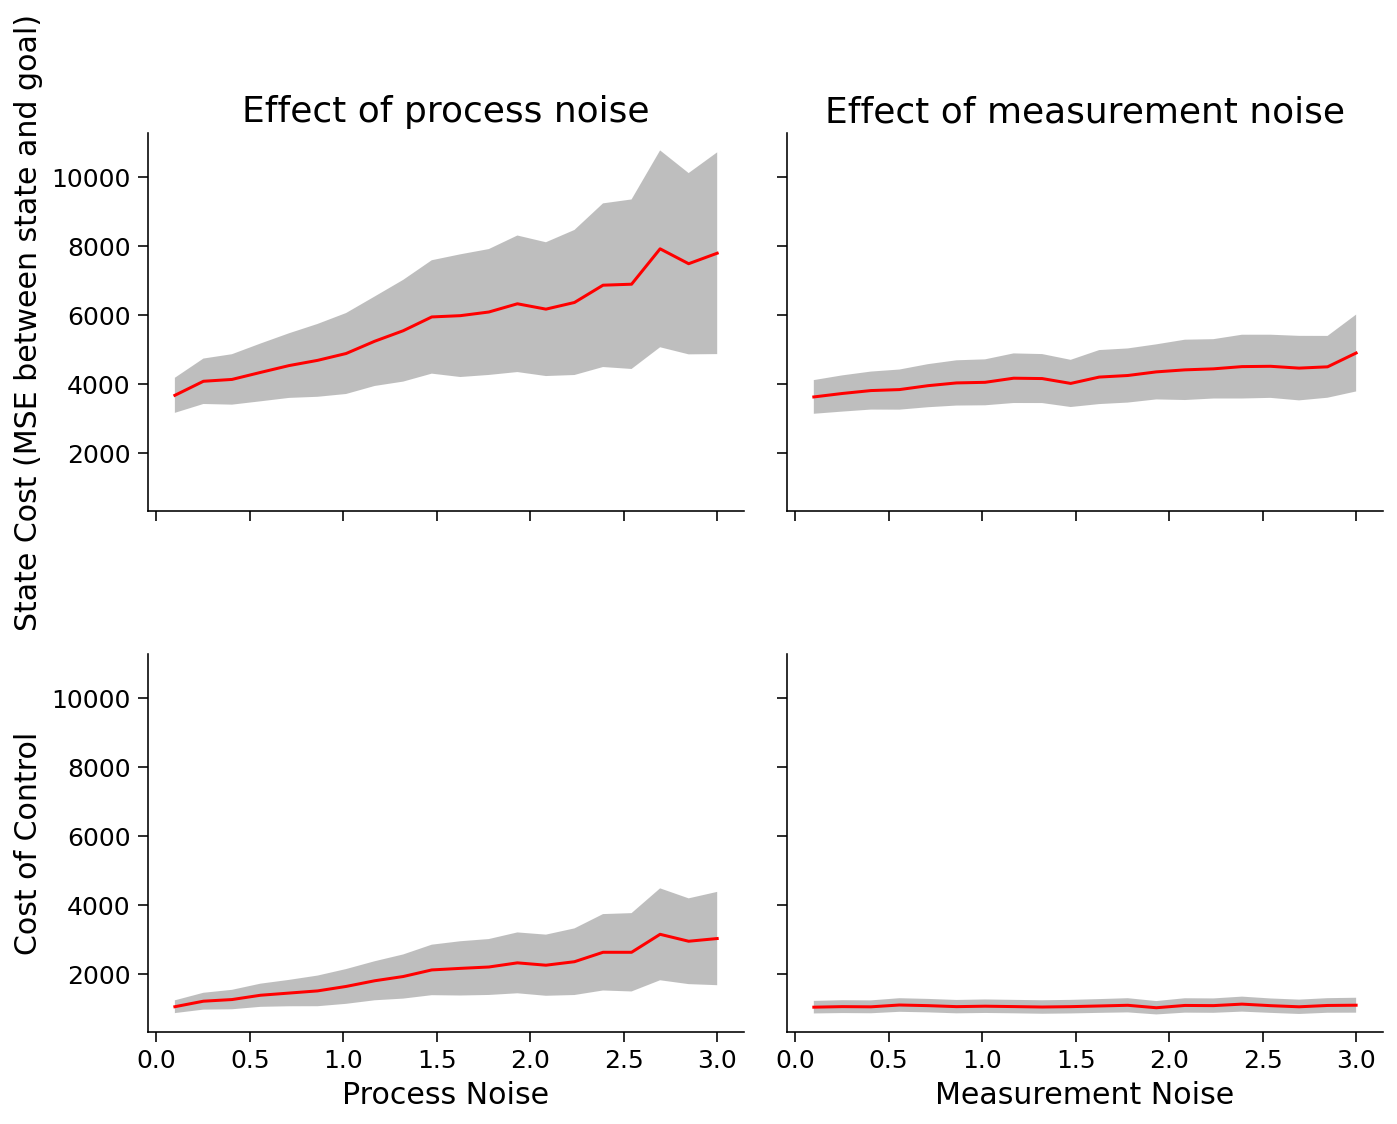

In [26]:
#@markdown Execute this cell to to quantify the dependence of state and control (Running many simulations takes time, you need to wait ~2 seconds before observing the consequences of changing the parameter D)

display(HTML('''<style>.widget-label { min-width: 15ex !important; }</style>'''))

D=1.1                           # transition matrix
C = 1                           # observation matrix
ini_state = 5                   # initial state mean
ini_state_cov = 1               # initial state covariance
rho = 1                         # control effort parameter
n_iter = 50
n_ops = 20
process_noise_var = .1
measurement_noise_var = .2

# Implement LQG control over n_iter iterations, and record the MSE between state and goal
MSE_array_N_meas = []
MSE_array_N_proc = []
Jcontrol_array_N_meas = []
Jcontrol_array_N_proc = []

meas_noise_array = np.linspace(0.1, 3, n_ops)
proc_noise_array = np.linspace(0.1, 3, n_ops)

# Try several proc noises, but same measurement var
MSE_array_proc = []
Jcontrol_array_proc = []

for proc_noise in proc_noise_array:
  transition_covariance = proc_noise
  observation_covariance = measurement_noise_var

  # Controller
  lqg = LQG(D, transition_covariance, C, observation_covariance, ini_state, ini_state_cov, n_iter)
  control_gain_lqg = lqg.get_control_gain_infinite(rho)

  # Filtering
  filter = KalmanFilter(D, transition_covariance, C, observation_covariance, ini_state, ini_state_cov)

  filtered_state_means_impl = np.zeros([T, n_iter])
  filtered_state_covariances_impl = np.zeros([T, n_iter])
  measurement = np.zeros([T, n_iter])
  action_cost = np.zeros([T, n_iter])

  action = np.zeros(n_iter)
  for t in range(1, T):
    measurement[t] = lqg.step(action)

    filter.get_estimate(measurement[t], action)

    filtered_state_means_impl[t] = filter.prior.mean
    filtered_state_covariances_impl = filter.prior.cov

    action = control_gain_lqg * filter.prior.mean
    action_cost[t] = rho * action**2

  state_cost = lqg.latent_states**2

  MSE_array_proc.append(np.cumsum(state_cost))
  Jcontrol_array_proc.append(np.cumsum(action_cost))

MSE_array_proc = np.array(MSE_array_proc)
Jcontrol_array_proc = np.array(Jcontrol_array_proc)

# Try several measurement noises, but same proc var
MSE_array_meas = []
Jcontrol_array_meas = []

for meas_noise in meas_noise_array:
  transition_covariance = process_noise_var
  observation_covariance = meas_noise

  # Controller
  lqg = LQG(D, transition_covariance, C, observation_covariance, ini_state, ini_state_cov, n_iter)
  control_gain_lqg = lqg.get_control_gain_infinite(rho)

  # Filtering
  filter = KalmanFilter(D, transition_covariance, C, observation_covariance, ini_state, ini_state_cov)

  filtered_state_means_impl = np.zeros([T, n_iter])
  filtered_state_covariances_impl = np.zeros([T, n_iter])
  measurement = np.zeros([T, n_iter])
  action_cost = np.zeros([T, n_iter])

  action = np.zeros(n_iter)
  for t in range(1, T):
    measurement[t] = lqg.step(action)

    filter.get_estimate(measurement[t], action)
    filtered_state_means_impl[t] = filter.prior.mean
    filtered_state_covariances_impl = filter.prior.cov

    action = control_gain_lqg * filter.prior.mean
    action_cost[t] = rho * action**2

  state_cost = lqg.latent_states**2

  MSE_array_meas.append(np.cumsum(state_cost))
  Jcontrol_array_meas.append(np.cumsum(action_cost))

MSE_array_meas = np.array(MSE_array_meas)
Jcontrol_array_meas = np.array(Jcontrol_array_meas)

# Compute statistics
MSE_array_proc_mean = np.mean(np.array(MSE_array_proc), axis = 1)
MSE_array_proc_std = np.std(np.array(MSE_array_proc), axis = 1)
MSE_array_meas_mean = np.mean(np.array(MSE_array_meas), axis = 1)
MSE_array_meas_std = np.std(np.array(MSE_array_meas), axis = 1)

Jcontrol_array_proc_mean = np.mean(np.array(Jcontrol_array_proc), axis = 1)
Jcontrol_array_proc_std = np.std(np.array(Jcontrol_array_proc), axis = 1)
Jcontrol_array_meas_mean = np.mean(np.array(Jcontrol_array_meas), axis = 1)
Jcontrol_array_meas_std = np.std(np.array(Jcontrol_array_meas), axis = 1)

# Visualize the quantification
f, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))

axs[0,0].plot(proc_noise_array, MSE_array_proc_mean, 'r-')
axs[0,0].fill_between(proc_noise_array, MSE_array_proc_mean+MSE_array_proc_std, MSE_array_proc_mean-MSE_array_proc_std, facecolor='tab:gray', alpha=0.5)
axs[0,0].set_title('Effect of process noise')
axs[0,0].set_ylabel('State Cost (MSE between state and goal)')

axs[0,1].plot(meas_noise_array, MSE_array_meas_mean, 'r-')
axs[0,1].fill_between(meas_noise_array, MSE_array_meas_mean+MSE_array_meas_std, MSE_array_meas_mean-MSE_array_meas_std, facecolor='tab:gray', alpha=0.5)
axs[0,1].set_title('Effect of measurement noise')

axs[1,0].plot(proc_noise_array, Jcontrol_array_proc_mean, 'r-')
axs[1,0].fill_between(proc_noise_array, Jcontrol_array_proc_mean+Jcontrol_array_proc_std, Jcontrol_array_proc_mean-Jcontrol_array_proc_std, facecolor='tab:gray', alpha=0.5)
axs[1,0].set_xlabel('Process Noise')
axs[1,0].set_ylabel('Cost of Control')

axs[1,1].plot(meas_noise_array, Jcontrol_array_meas_mean, 'r-')
axs[1,1].fill_between(meas_noise_array, Jcontrol_array_meas_mean+Jcontrol_array_meas_std, Jcontrol_array_meas_mean-Jcontrol_array_meas_std, facecolor='tab:gray', alpha=0.5)
axs[1,1].set_xlabel('Measurement Noise')

plt.show()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D3_OptimalControl/solutions/W3D3_Tutorial2_Solution_377b4dee.py)



---
# Summary

In this tutorial, you have extended the idea of optimal policy to the Astrocat example. You have learned about how to design an optimal controller with a full observation of the state (linear quadratic regulator - LQR) and under partial observability of the state (linear quadratic gaussian - LQG).